In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


In [ ]:
img_height, img_width = 224, 224
batch_size = 16

dir = 'dataset'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    os.path.join(dir, 'validation'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

Found 240 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [ ]:
base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [66]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    #callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.5115 - loss: 1.0221 - val_accuracy: 0.7167 - val_loss: 0.6221
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.6877 - loss: 0.5972 - val_accuracy: 0.7167 - val_loss: 0.5727
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.6868 - loss: 0.5876 - val_accuracy: 0.7167 - val_loss: 0.5635
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8446 - loss: 0.4094 - val_accuracy: 0.7500 - val_loss: 0.5395
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8130 - loss: 0.4079 - val_accuracy: 0.7667 - val_loss: 0.5190
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - accuracy: 0.8664 - loss: 0.3386 - val_accuracy: 0.7667 - val_loss: 0.4758
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.7770 - loss: 0.4450 - val_accuracy: 0.7833 - val_loss: 0.4756
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.8064 - loss: 0.4195 - val_accuracy: 0.8167 - val_loss: 0.4565
Epoch 9/

KeyboardInterrupt: 

In [31]:
model.save('garukkucingv3.h5')

In [32]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    os.path.join(dir, 'test'),  
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

loss,acc=model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {acc*100:.2f}%\nTest Loss: {loss:.4f}")

Found 300 images belonging to 2 classes.
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9450 - loss: 0.1624
Test Accuracy: 94.00%
Test Loss: 0.1517


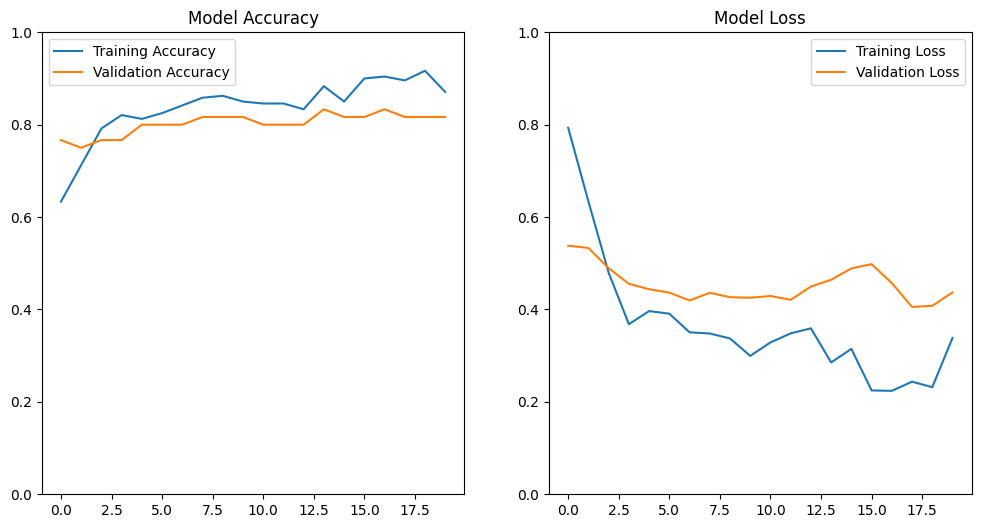

In [33]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylim(0,1)
plt.legend()

plt.show()

In [34]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)[0][0]
    label = 'scratching' if prediction > 0.5 else 'not scratching'
    print(f"Prediction: {label} ({prediction:.2f})")


In [48]:
from tensorflow.keras.models import load_model

model = load_model('garukkucingv3.h5')

In [49]:
# fine tune
base_model = model.layers[0]
base_model.trainable = True

for layer in base_model.layers[:-10]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [50]:
history_finetune = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    #callbacks=[early_stopping],
    verbose=1
)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.8313 - loss: 0.3972 - val_accuracy: 0.8167 - val_loss: 0.4339
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.8256 - loss: 0.4261 - val_accuracy: 0.8167 - val_loss: 0.4328
Epoch 3/20


KeyboardInterrupt: 

I've tried multiple run with different parameter on the fine-tuning, yet the pre-fine tuned model somewhat perform better, this might happen because the dataset used is too small for a proper fine tuning.

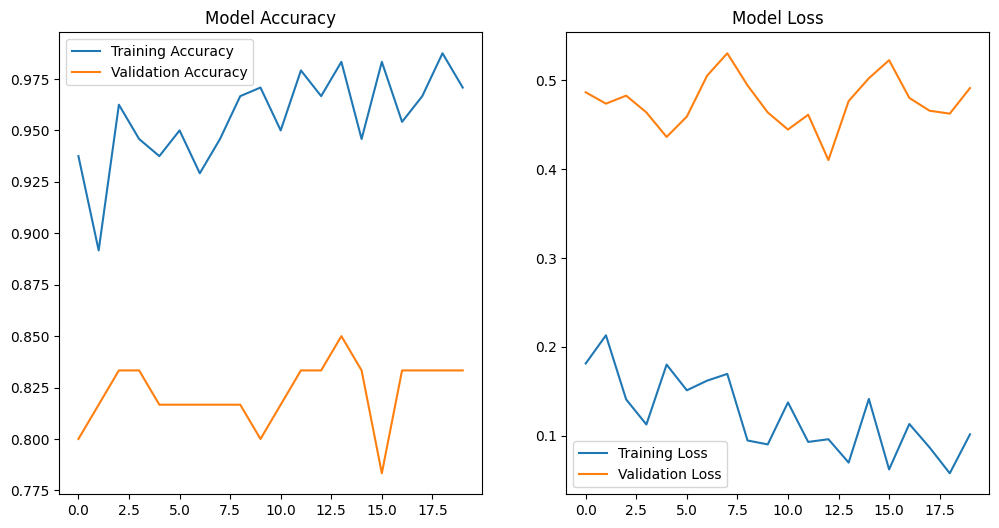

In [74]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

It could be seen from the graph that the model training seems to be fine.

From the histogram it could be seen that most of the predictions are clustered near 0 or 1, Claude told me this is a good thing, meaning the model is more confident on making the predictions (considenring the increase in accuracy). Thanks Claude! Now, I'm happy with the model I've train.

In [13]:

predict_image('tes ai1.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Prediction: scratching (1.00)


In [9]:
import tf2onnx
# Method using the newer API
model = load_model('garukkucingv2.h5')

input_layer = tf.keras.Input(shape=(img_height, img_width, 3), name='input_image')
outputs = model(input_layer)
fixed_model = tf.keras.Model(inputs=input_layer, outputs=outputs, name='fixed_model')

onnx_model, _ = tf2onnx.convert.from_keras(
    fixed_model, 
    input_signature=[tf.TensorSpec([None, img_height, img_width, 3], tf.float32)],
    opset=11  # Try lower opset version
)

with open('garukkucingv2.onnx', 'wb') as f:
    f.write(onnx_model.SerializeToString())

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x0000020DA900E5C0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.
